In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import scipy.stats as stats

WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
%config InlineBackend.figure_format = 'retina'
%load_ext watermark
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")

#### Code 3.1

In [3]:
# Probability of a positive test given the subject is a vampire
# P(P|V)
PrPV = 0.95

# P(P|M)
# Probability of a positive test given the subject is a mortal
PrPM = 0.01

# Probability a member of the population is a vampire
PrV = 0.001

# Use Bayes theorem to invert the probability
# P(Pos) is the average probability of a positive test result
PrP = PrPV * PrV + PrPM * (1 - PrV)
# P(V|P)
PrVP = PrPV * PrV / PrP
PrVP

0.08683729433272395

#### Code 3.2 - 3.5

We are going to use the same function we use on chapter 2 (code 2.3)

In [4]:
def uniform_prior(grid_points):
    """
    Returns Uniform prior density

            Parameters:
                grid_points (numpy.array): Array of prior values

            Returns:
                density (numpy.array): Uniform density of prior values
    """
    return np.repeat(5, grid_points)


def truncated_prior(grid_points, trunc_point=0.5):
    """
    Returns Truncated prior density

            Parameters:
                grid_points (numpy.array): Array of prior values
                trunc_point (double): Value where the prior is truncated

            Returns:
                density (numpy.array): Truncated density of prior values
    """
    return (np.linspace(0, 1, grid_points) >= trunc_point).astype(int)


def double_exp_prior(grid_points):
    """
    Returns Double Exponential prior density

            Parameters:
                grid_points (numpy.array): Array of prior values

            Returns:
                density (numpy.array): Double Exponential density of prior values
    """
    return np.exp(-5 * abs(np.linspace(0, 1, grid_points) - 0.5))

In [5]:
def binom_post_grid_approx(prior_func, grid_points=5, success=6, tosses=9):
    """
    Returns the grid approximation of posterior distribution with binomial likelihood.

            Parameters:
                    prior_func (function): A function that returns the likelihood of the prior
                    grid_points (int): Number of points in the prior grid
                    successes (int): Number of successes
                    tosses (int): number of tosses

            Returns:
                    p_grid (numpy.array): Array of prior values
                    posterior (numpy.array): Likelihood (density) of prior values
    """
    # define grid
    p_grid = np.linspace(0, 1, grid_points)

    # define prior
    prior = prior_func(grid_points)

    # compute likelihood at each point in the grid
    likelihood = stats.binom.pmf(success, tosses, p_grid)

    # compute product of likelihood and prior
    unstd_posterior = likelihood * prior

    # standardize the posterior, so it sums to 1
    posterior = unstd_posterior / unstd_posterior.sum()
    return p_grid, posterior

##### Sampling from a Grid-Approximate Posterior

In [6]:
p_grid, posterior = binom_post_grid_approx(uniform_prior, grid_points=100, success=6, tosses=9)
samples = np.random.choice(p_grid, p=posterior, size=10000, replace=True)

/opt/anaconda3/lib/python3.8/site-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


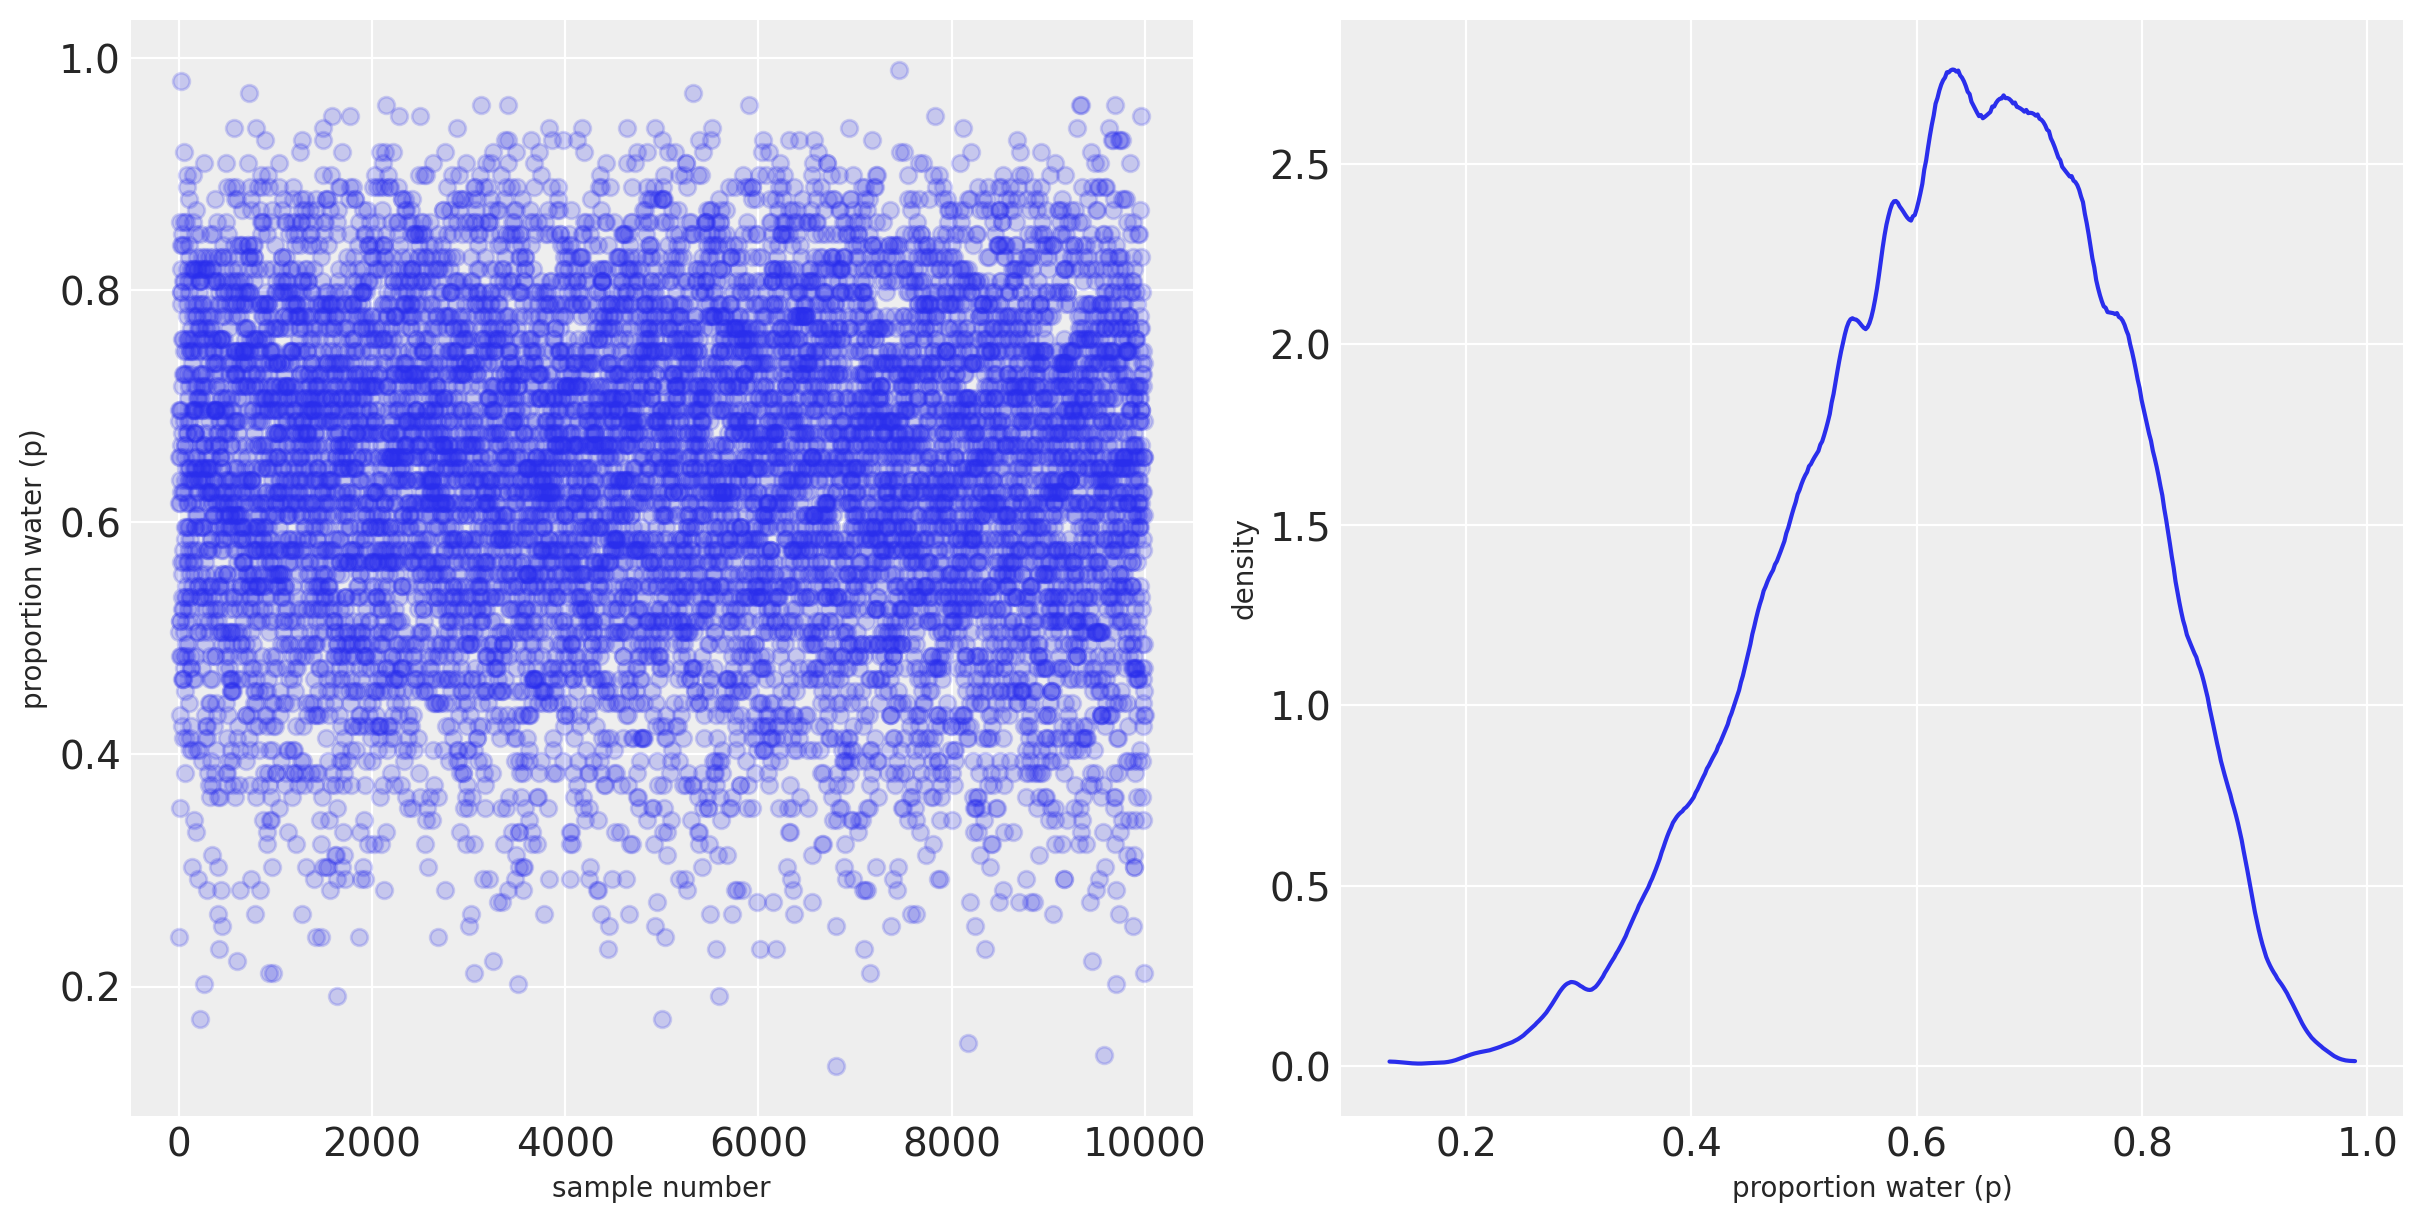

In [7]:
_, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 6))
ax0.plot(samples, "o", alpha=0.2)
ax0.set_xlabel("sample number")
ax0.set_ylabel("proportion water (p)")
az.plot_kde(samples, ax=ax1)
ax1.set_xlabel("proportion water (p)")
ax1.set_ylabel("density");

##### Sampling to Summarize

Once your model produces a posterior distribution, the model’s work is done. But your work has just begun. It is necessary to summarize and interpret the posterior distribution. Exactly how it is summarized depends upon your purpose. But common questions include:
- How much posterior probability lies below some parameter value?
- How much posterior probability lies between two parameter values?
- Which parameter value marks the lower 5% of the posterior probability?
- Which range of parameter values contains 90% of the posterior probability?
- Which parameter value has highest posterior probability?

These simple questions can be usefully divided into questions about 
1. Intervals of defined boundaries
2. Questions about intervals of defined probability mass
3. Questions about point estimates

#### Code 3.6

**Intervals of defined boundaries:** Suppose I ask you for the posterior probability that the proportion of water is less than 0.5. Using the grid-approximate posterior, you can just add up all of the probabilities, where the corresponding parameter value is less than 0.5:

In [8]:
sum(posterior[p_grid < 0.5])

0.17183313110747475

#### Code 3.7

So let’s see how to perform the same calculation, using samples from the posterior. This
approach does generalize to complex models with many parameters, and so you can use
it everywhere. All you have to do is similarly add up all of the samples below 0.5, but also
divide the resulting count by the total number of samples. In other words, find the frequency
of parameter values below 0.5:

In [8]:
sum(samples < 0.5) / 1e4

0.1699

#### Code 3.8

Using the same approach, you can ask how much posterior probability lies between 0.5 and 0.75:

In [9]:
sum((samples > 0.5) & (samples < 0.75)) / 1e4

0.6089

#### Code 3.9

It is more common to see scientific journals reporting an interval of defined mass, usually known as a confidence interval. An interval of posterior probability, such as the ones we are working with, may instead be called a credible interval, although the terms may also be used interchangeably.

Suppose for example you want to know the boundaries of the lower 80% posterior probabil-
ity. You know this interval starts at p = 0. To find out where it stops, think of the samples
as data and ask where the 80th percentile lies:

In [10]:
np.percentile(samples, 80)

0.7676767676767677

#### Code 3.10

Similarly, the middle 80% interval
lies between the 10th percentile and the 90th percentile. These boundaries are found using
the same approach:

In [11]:
np.percentile(samples, [10, 90])

array([0.45454545, 0.81818182])

#### Code 3.11

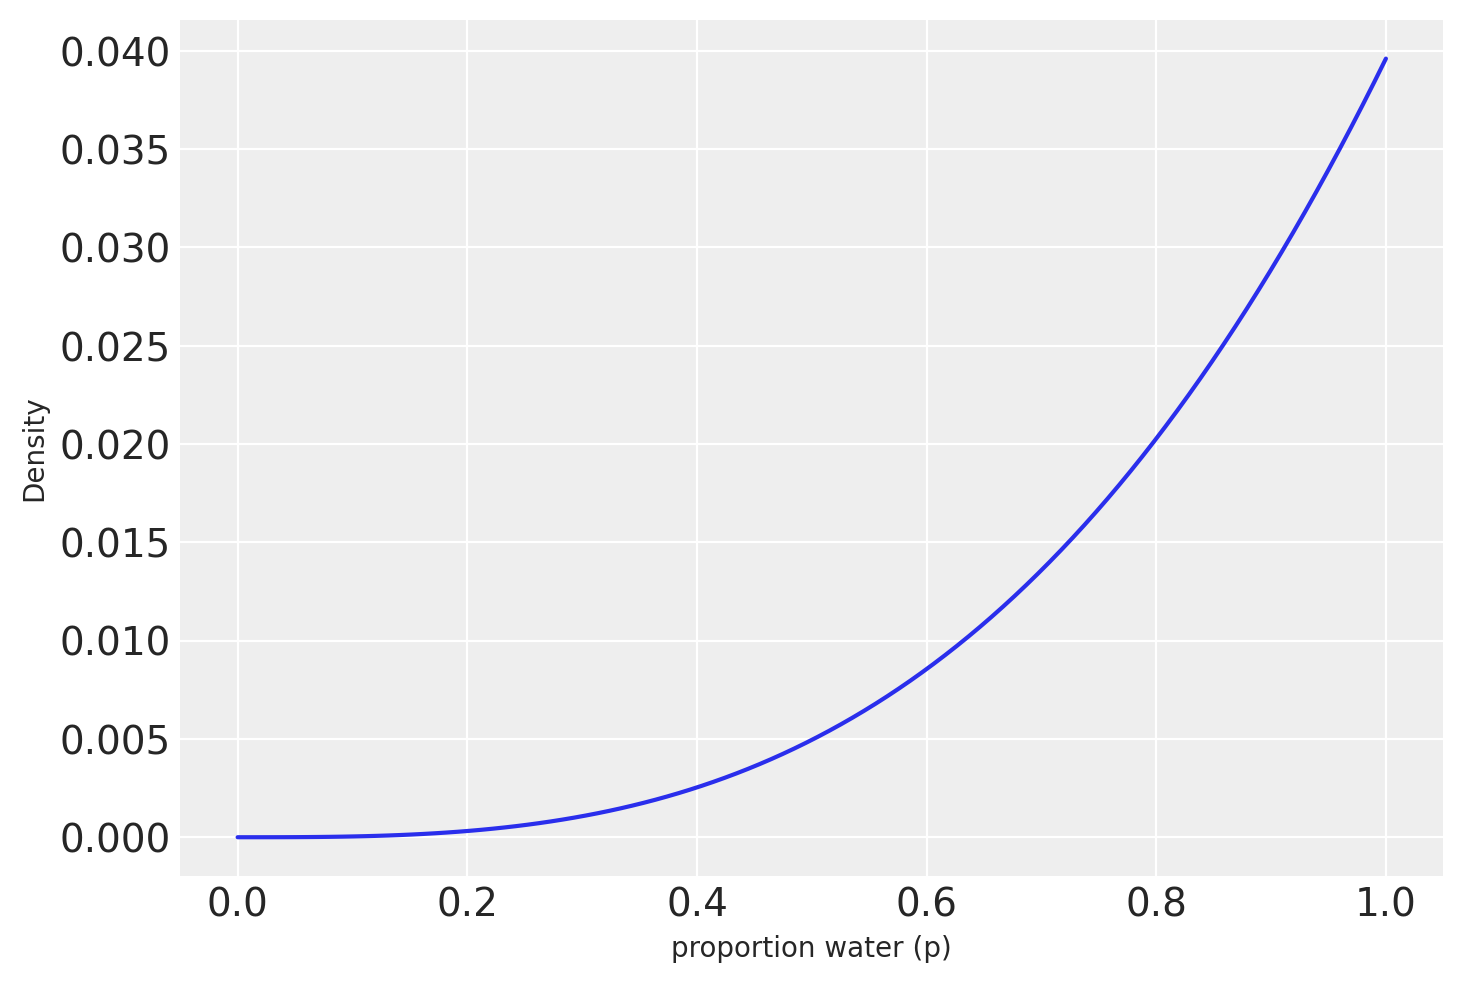

In [13]:
p_grid, posterior = binom_post_grid_approx(uniform_prior, grid_points=100, success=3, tosses=3)
plt.plot(p_grid, posterior)
plt.xlabel("proportion water (p)")
plt.ylabel("Density");

#### Code 3.12

In [14]:
samples = np.random.choice(p_grid, p=posterior, size=int(1e4), replace=True)
np.percentile(samples, [25, 75])

array([0.70707071, 0.93939394])

#### Code 3.13

In [15]:
az.hdi(samples, hdi_prob=0.5)

array([0.84848485, 1.        ])

#### Code 3.14

In [16]:
p_grid[posterior == max(posterior)]

array([1.])

#### Code 3.15

In [17]:
stats.mode(samples)[0]

/var/folders/nd/7h3lcr8d2cjbxfmfqghczqz40000gn/T/ipykernel_35040/194067309.py:1: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  stats.mode(samples)[0]


array([0.96969697])

#### Code 3.16

In [18]:
np.mean(samples), np.median(samples)

(0.8039616161616162, 0.8484848484848485)

#### Code 3.17

In [19]:
sum(posterior * abs(0.5 - p_grid))

0.31626874808692995

#### Code 3.18 and 3.19

In [20]:
loss = [sum(posterior * abs(p - p_grid)) for p in p_grid]
p_grid[loss == min(loss)]

array([0.84848485])

#### Code 3.20

In [21]:
stats.binom.pmf(range(3), n=2, p=0.7)

array([0.09, 0.42, 0.49])

#### Code 3.21

In [22]:
stats.binom.rvs(n=2, p=0.7, size=1)

array([1])

#### Code 3.22

In [23]:
stats.binom.rvs(n=2, p=0.7, size=10)

array([2, 2, 1, 1, 1, 2, 2, 0, 2, 1])

#### Code 3.23

In [24]:
dummy_w = stats.binom.rvs(n=2, p=0.7, size=int(1e5))
[(dummy_w == i).mean() for i in range(3)]

[0.09088, 0.42142, 0.4877]

#### Code 3.24, 3.25, and 3.26

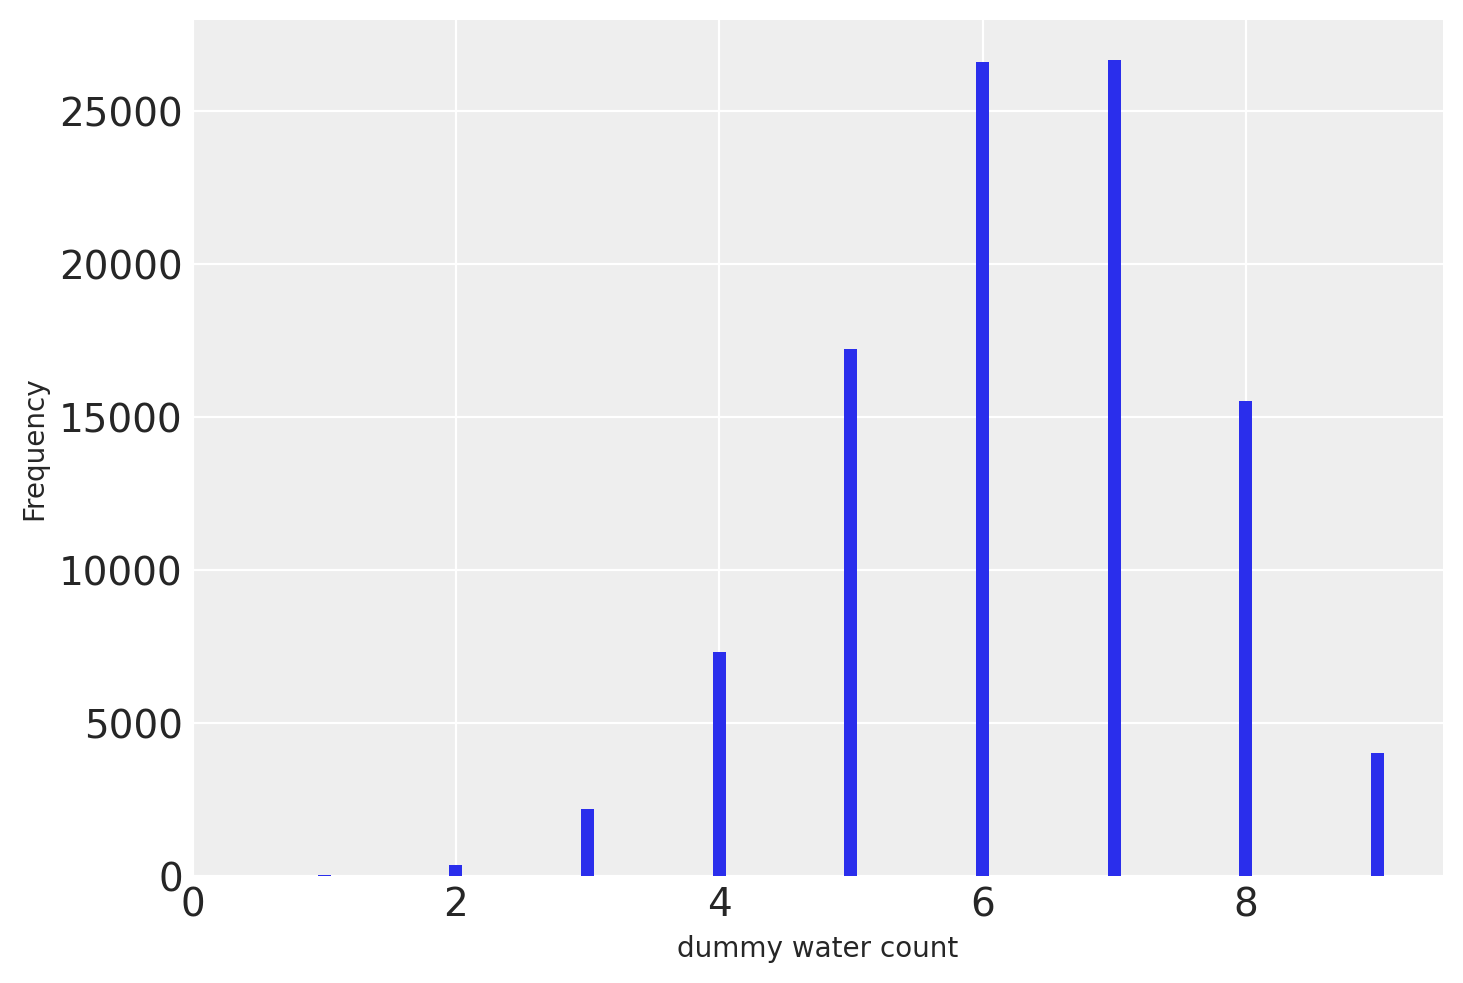

In [25]:
dummy_w = stats.binom.rvs(n=9, p=0.7, size=int(1e5))
bar_width = 0.1
plt.hist(dummy_w, bins=np.arange(0, 11) - bar_width / 2, width=bar_width)
plt.xlim(0, 9.5)
plt.xlabel("dummy water count")
plt.ylabel("Frequency");

#### Code 3.27

In [28]:
p_grid, posterior = binom_post_grid_approx(uniform_prior, grid_points=100, success=6, tosses=9)
np.random.seed(100)
samples = np.random.choice(p_grid, p=posterior, size=int(1e4), replace=True)
samples

array([0.65656566, 0.55555556, 0.61616162, ..., 0.5959596 , 0.36363636,
       0.44444444])

#### Code 3.28

In [29]:
birth1 = np.array([1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0,
                   1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1])
birth2 = np.array([0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0,
                   1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
                   1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1,
                   0, 0, 0, 1, 1, 1, 0, 0, 0, 0])

#### Code 3.30

In [30]:
sum(birth1) + sum(birth2)

111

# End of Chapter Problems

In [12]:
data = np.array([1, 0, 1, 1, 1, 0, 1, 0, 1])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor

/opt/anaconda3/lib/python3.8/site-packages/pytensor/scalar/basic.py:3054: RuntimeWarning: divide by zero encountered in log1p
  return np.log1p(x)
/opt/anaconda3/lib/python3.8/site-packages/pytensor/tensor/elemwise.py:781: RuntimeWarning: divide by zero encountered in impl (vectorized)
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
/opt/anaconda3/lib/python3.8/site-packages/pytensor/scalar/basic.py:1998: RuntimeWarning: divide by zero encountered in divide
  return x / y
/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.


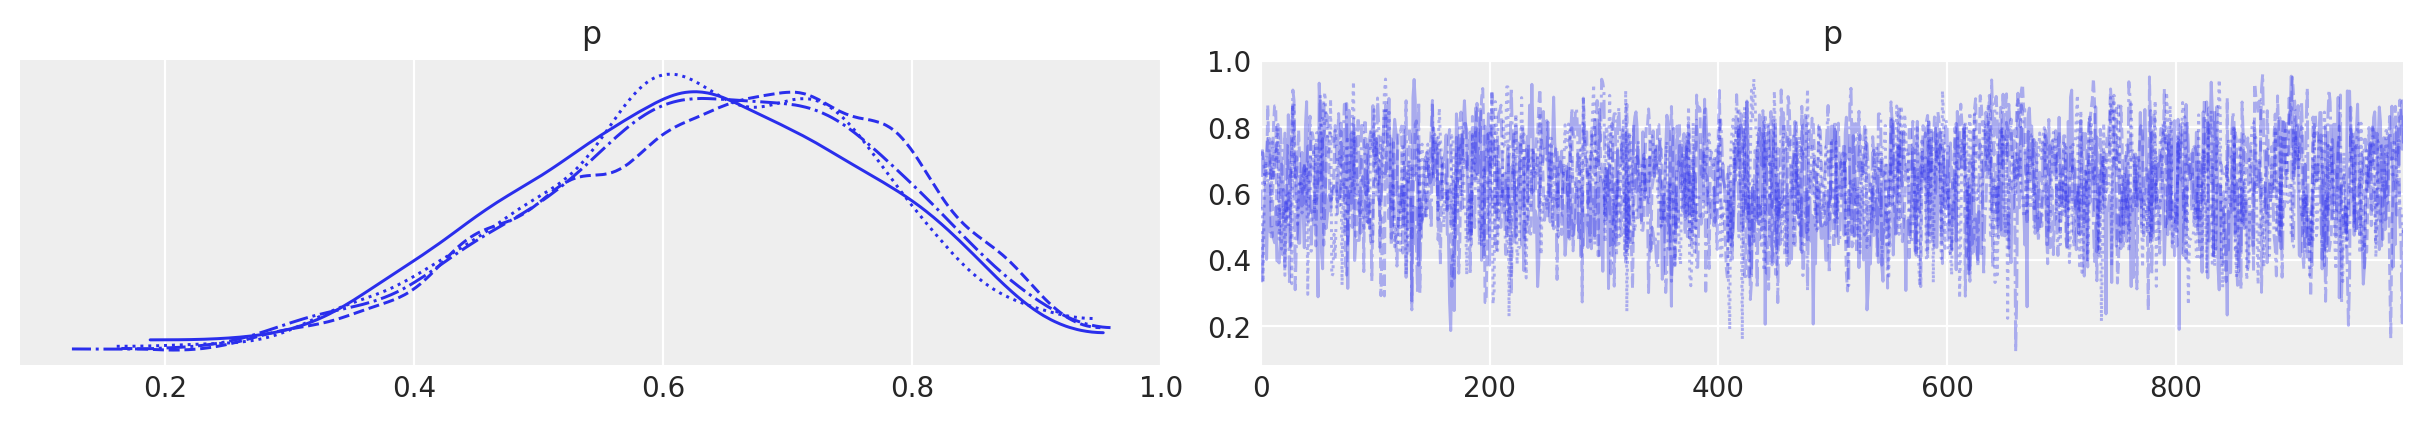

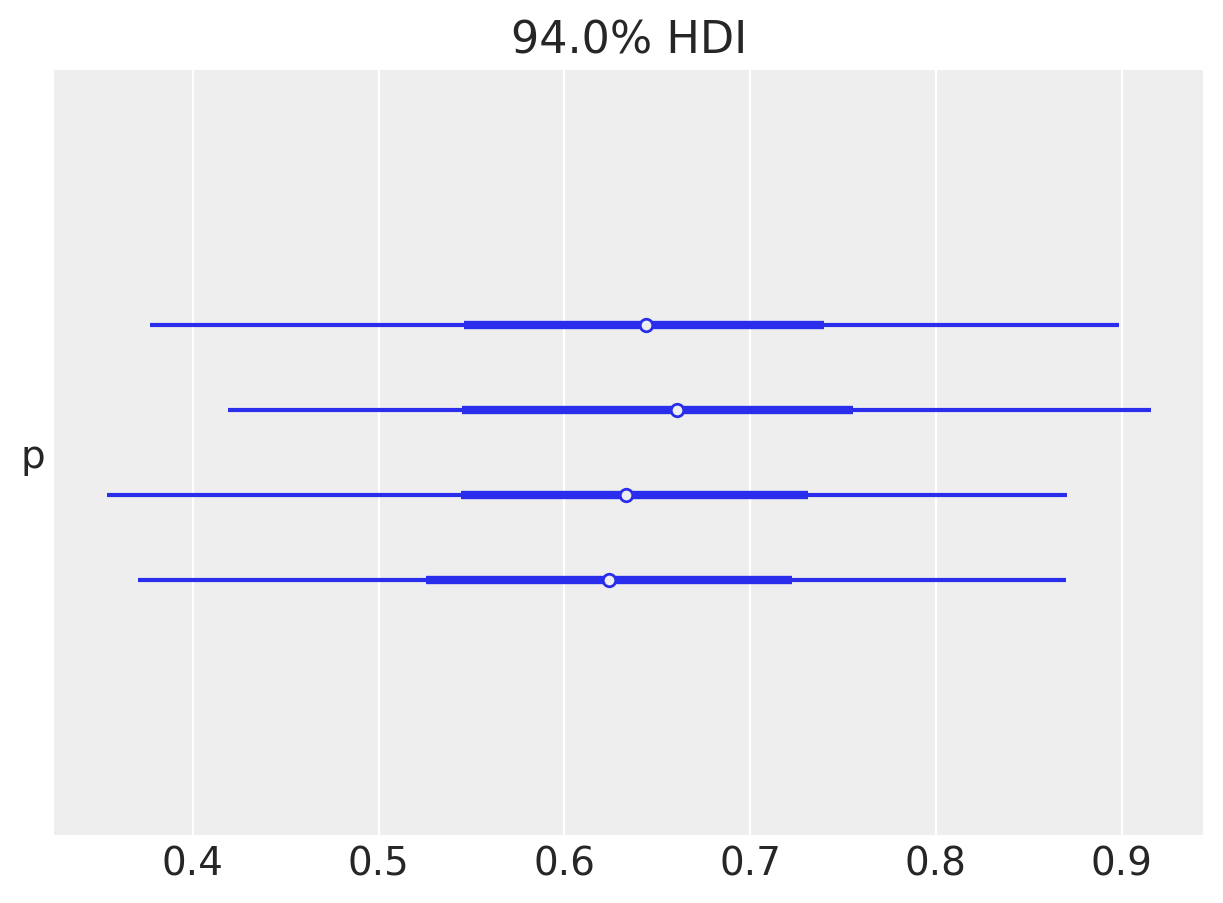

In [17]:
with pm.Model() as our_first_model:
    p = pm.Uniform("p")  # set the prior
    y = pm.Bernoulli("y", p=p, observed=data)  # set the posterior
    trace = pm.sample(1000, chains=4)  # get 1000 random_samples
    az.plot_trace(trace)
    az.plot_forest(trace, var_names=["p"])

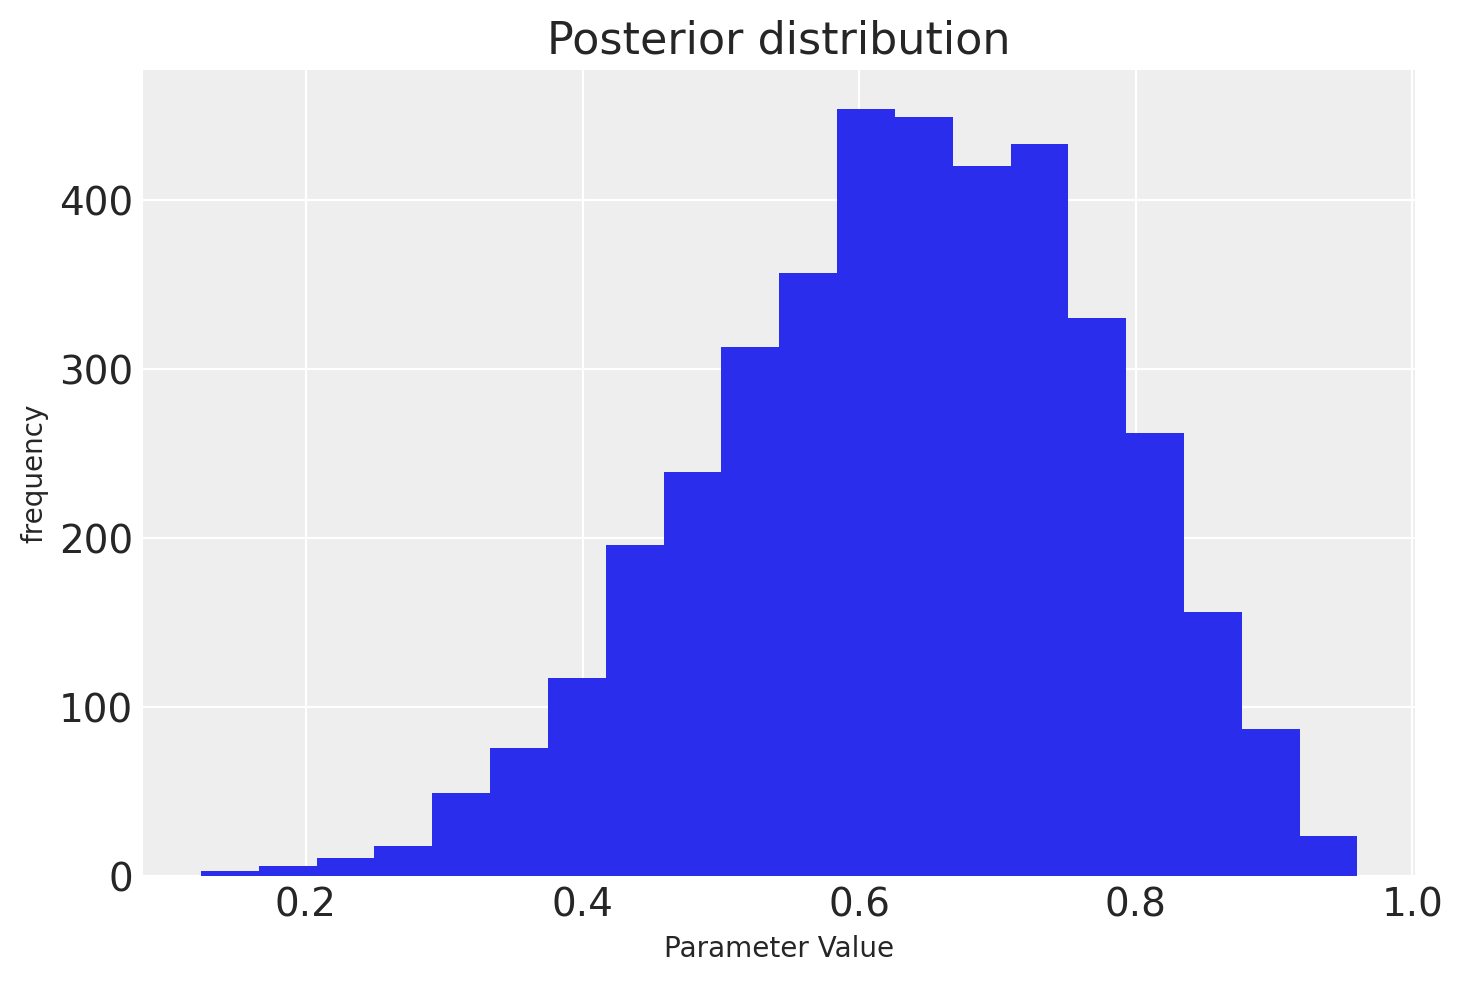

In [18]:
# plot the posterior
plt.hist(trace.posterior["p"].values.flatten(), bins=20)
plt.title("Posterior distribution")
plt.ylabel("frequency")
plt.xlabel("Parameter Value");

## 3E1.

How much posterior probability lies below p = 0.2?

In [20]:
samples = trace.posterior["p"].values.flatten()
print(str(np.sum(samples < 0.2) / samples.size) + " of the posterior lies below 0.2")

0.0015 of the posterior lies below 0.2


## 3E2.

How much posterior probability lies above p = 0.8?

In [21]:
print(str(np.sum(samples > 0.8) / samples.size) + " of the posterior lies above 0.8")

0.11825 of the posterior lies above 0.8
The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


## 3E3.

How much posterior probability lies between p = 0.2 and p = 0.8?

In [22]:
print(
    str(1 - np.sum(samples > 0.8) / samples.size - np.sum(samples < 0.2) / samples.size)
    + " of the posterior lies between 0.2 & 0.8"
)

0.8802500000000001 of the posterior lies between 0.2 & 0.8


## 3E4.

20% of the posterior probability lies below which value of p?

In [23]:
print("The 20% quantile of the posterior is " + str(np.quantile(samples, 0.2)))

The 20% quantile of the posterior is 0.5120426497228285


## 3E5.

20% of the posterior probability lies above which value of p?

In [25]:
print("20% of the probability mass lies above " + str(np.quantile(samples, 0.8)))

20% of the probability mass lies above 0.7583465623729485


## 3E6.

Which values of p contain the narrowest interval equal to 66% of the posterior probability?

In [26]:
hpd_interval = az.hdi(samples, hdi_prob=0.66)
print(hpd_interval)

[0.53253648 0.80695148]


Sanity checking this, it's seen that the interval does in fact contain around 66% of the mass

In [27]:
print(
    str(
        1
        - np.sum(samples > hpd_interval[1]) / samples.size
        - np.sum(samples < hpd_interval[0]) / samples.size
    )
)

0.66025


## 3E7.

Which values of p contain 66% of the posterior probability, assuming equal posterior probability both below and above the interval?

In [28]:
np.quantile(samples, (1 / 6, 5 / 6))

array([0.49254399, 0.77425747])